In [326]:
# scientific computing libraries
import numpy as np
# plotting libraries
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# optimization libraries
from scipy.optimize import minimize
# random number libraries
import random
# other
import copy
from dataclasses import dataclass
from typing import List, Dict, Tuple, Callable
from scipy.stats import qmc

# 1. Overview of the Problem

We have a dataset of $n_d$ experimental points from a bioprocess:

$$
\mathcal{D} \;=\; \bigl\{ (\mathbf{x}_1, f(\mathbf{x}_1)), (\mathbf{x}_2, f(\mathbf{x}_2)), \ldots, (\mathbf{x}_{n_d}, f(\mathbf{x}_{n_d})) \bigr\}.
$$

We assume:
- $\mathbf{x} \in \mathbb{R}^{n_x}$ represents the input variables (e.g., operating conditions, feed rates, temperature setpoints, etc.).
- $f(\mathbf{x})$ is the unknown function describing the relationship between $\mathbf{x}$ and some output of interest (e.g., yield, productivity, etc.).

We want to find (or “learn”) $f(\mathbf{x})$ by combining only a few “leaf functions”:

- $ \mathbf{x} $  
- etc. (await leaf functions from Laura)

where $ A \in \mathbb{R}^{n_x \times n_x} $ is a matrix, and products such as $ \mathbf{x} \ln(\mathbf{x}) $ or $ \mathbf{x} \sin(\mathbf{x}) $ act element-wise.

#### We break the problem into:
1. **Model Construction**: Determine which leaf functions (or subset thereof) are truly relevant for $ f(\mathbf{x}) $.  
2. **Parameter Estimation**: Estimate the coefficients and parameters (e.g., matrix $ A $, weighting coefficients, etc.) for the chosen functions.


# 2. Parameter Estimation

Now that we have introduced the problem, let's assume the functional form of the system we are studying:

$$f(x_1,x_2; \Theta) = \theta_1 + \theta_2x_1x_2+\theta_3x_2\log(x_1) + \theta_4 x_1 \sin(x_2) $$

Our goal is to estimate the values of the parameters $\Theta=[ \theta_1, \theta_2, \theta_3, \theta_4]$.

We will:

1. Generate synthetic data based on known parameter values for $\Theta$.
2. Use an optimisation algorithm to estimate $\Theta$ by matching the model to the data.

### Step 1: Generating Synthetic Data
We define a hidden function that generates the data, simulating an unknown process. The dataset will help us test our method for estimating the parameters.

In [327]:
def true_function(x1: float, x2: float) -> float:
    """
    True function to be discovered by our model.
    f(x1, x2) = θ_1 + θ_2*x1*x2 + θ_3*x2*log(x1) + θ_4*x1*sin(x2)
    """
    theta = [3, 0.1, 0.5, 1.5]
    return theta[0] + theta[1] * x1 * x2 + theta[2] * x2 * np.log(x1 + 0.1) + theta[3] * x1 * np.sin(x2)

def generate_data(n_samples=200, noise_std=0.1, x_bounds=(0, 25), random_seed=42):
    """Generate synthetic data with noise for model testing."""
    np.random.seed(random_seed)
    X_data = np.random.uniform(x_bounds[0], x_bounds[1], (n_samples, 2))
    y_true = true_function(X_data[:, 0], X_data[:, 1])
    return X_data, y_true #+ np.random.normal(0, noise_std, n_samples)

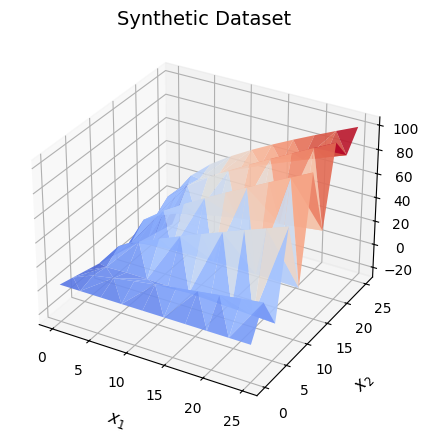

In [328]:
# Generate grid to visualise data
x_range = np.linspace(0,25,10)
x1, x2 = np.meshgrid(x_range,x_range)
X_data = np.column_stack((x1.ravel(), x2.ravel()))
y_data = np.array([true_function(x1, x2) for x1, x2 in X_data])

# Visualise dataset
fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111, projection='3d')

# Plot settings
ax.set_title('Synthetic Dataset', fontsize=14)
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$f(x_1, x_2)$', fontsize=12, labelpad=10)

# 3D surface plot
ax.plot_trisurf(X_data[:, 0], X_data[:, 1], y_data, cmap='coolwarm', linewidth=0, alpha=0.9)
plt.show()

### Step 2: Estimating Parameters via Optimisation

To estimate the parameters, we minimise the **difference** between the model prediction and the observed data by manupulating parameters $\Theta$. The difference is measured using a **least squares error function**:

$$\min_\Theta ~ \frac{1}{n_d} \sum_{i=0}^{n_d} \left( \hat{f}_{\hat{x}_1^{(i)},\hat{x}_2^{(i)}} - f \left(\Theta;x_1^{(i)},x_2^{(i)} \right) \right)^2$$

where $\hat{f}_{\hat{x}_1^{(i)},\hat{x}_2^{(i)}}$ is the **true** function value for the datapoint at $x_1^{(i)},x_2^{(i)}$, and $f \left(\Theta;x_1^{(i)},x_2^{(i)} \right)$ is the function you are trying to estimate, at $x_1^{(i)},x_2^{(i)}$ with parameters $\Theta$.


In [329]:
# Least squares function
def least_squares(theta, X_data, y_data):
    """Calculates the least squares error for given parameters.
    Parameters:
    - theta: list of parameters [theta1, theta2, theta3, theta4]
    - X_data: array of input data points [[x1, x2], ...]
    - y_data: array of observed function values [f(x1, x2), ...]

    Returns:
    - error: least squares error
    """
    a, b, c, d = theta  # Unpack parameters
    error = np.mean([(a + b * x[0] * x[1] + c * x[1] * np.log(x[0] + 0.1) +
                      d * x[0] * np.sin(x[1]) - f) ** 2 for x, f in zip(X_data, y_data)])
    return error

#### Choosing an Optimisation Algorithm
Rather than using a generic optimiser, we’ll explore metaheuristic algorithms that mimic natural phenomena and are easy to implement. Examples include:

- Particle Swarm Optimisation: Mimics the behaviour of a swarm (e.g., birds searching for food).
- Differential Evolution: Mimics evolutionary processes to explore the solution space.

For now, let's start with a simpler method, scipy.optimize.minimize, to build intuition.

In [330]:
# Dataset for optimisation
X_data, y_data = generate_data(n_samples=20, x_bounds=(0,10))

# Random initial guess for parameters
initial_guess = [3, 0.8, 3, 0.4]

# Minimise the least squares error
result = minimize(least_squares, args=(X_data, y_data), x0=initial_guess, method='Powell')

# Print the estimated parameters and least squares value
print("Estimated Parameters:", result.x)
print("Least Squares Value:", result.fun)

Estimated Parameters: [3.  0.1 0.5 1.5]
Least Squares Value: 3.338687221946657e-22


#### Example Algorithm - Random Search

In [331]:
def Random_search(least_squares, X_data, y_data, bounds_rs, n_p, iter_rs):
    '''
    This function is a naive optimization routine that randomly samples the
    allowed space and returns the best value.
    '''

    # arrays to store sampled points
    localx   = np.zeros((n_p,iter_rs))    # points sampled
    localval = np.zeros((iter_rs))        # function values sampled

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(bounds_rs[0], bounds_rs[1], n_p) # sampling
        localx[:,sample_i] = x_trial
        localval[sample_i] = least_squares(x_trial, X_data, y_data)
    # choosing the best
    minindex = np.argmin(localval)
    f_b      = localval[minindex]
    x_b      = localx[:,minindex]
    return f_b,x_b

In [332]:
bounds_rs_ = [0, 10] # this assumes all bounds are the same
n_p_       = 4
iter_rs_   = 1000

f_bRS, x_bRS = Random_search(least_squares, X_data, y_data, bounds_rs_, n_p_, iter_rs_)
print('best point RS: ',x_bRS)
print('best value RS: ',f_bRS)

best point RS:  [2.20852783 0.38929963 0.36018818 1.75221772]
best value RS:  45.61151791177602


# 3. Model Construction with a Search Algorithm

- **Problem:** We have many possible “leaf” functions (e.g., $x_1$, $x_1^2$, $x_1 \sin(x_2)$, etc.). We want to decide which ones actually belong in our model:

$$
f(x; \Theta, y) = \sum_{\text{possible leaf}} y_i \,[\text{leaf}_i(x)]
$$
$$
y_i = 
\begin{cases}
1, & \text{if leaf function } i \text{ is included},\\
0, & \text{if leaf function } i \text{ is excluded}.
\end{cases}
$$
- **Challenge:** If we use all possible leaf functions, we risk having a huge (overfitted) model. So we add a penalty on the number of functions we include. This introduces a binary variable $y$ and results in:

$$
\min_{\Theta, y} \; 
\frac{1}{n_d}
\sum_{i=1}^{n_d} 
\Bigl(f_{\text{data}}(x^{(i)}) - f_{\text{model}}(x^{(i)}; \Theta, y)\Bigr)^2
\;+\;
\lambda \sum_{j=1}^{n_y} y_j.
$$

- **Solution:** We combine:
  1. **Parameter Estimation (PE)** for a given choice of $y$.
  2. **Search or “model building”** across different $y$ patterns (which leaf functions are included).

### Algorithm Outline

1. Initial Candidates
    - Randomly generate a set of binary vectors $y$. Each vector indicates a potential model structure (which leafs are included).  
    - For each $y$, we run parameter estimation to find the best $\Theta$. This is similar to the “PE” section, but now we only estimate parameters for the leafs we turned on.

2. Evaluate & Store
    - We compute the penalised least squares error for each candidate, storing the result in a dictionary.

3. Mutation / Local Search
    - We take the best-performing candidates, “mutate” their $y$ (flip some bits from 0 to 1 or 1 to 0) to explore new models.
    - Each new $y$ again triggers a parameter estimation step.
    - We keep track of any improved (or new) models found.

4. Repeat
    - Continue generating new models and updating parameters until we reach a stopping condition.



#### Key Components

- ```ModelConfig```: Contains hyperparameters for the model building process
- ```generate_data```: Creates synthetic data from our true function
- ```BasisFunction```: Represents individual terms in our model
- ```ModelBuilder```: The main class that handles model construction
- ```evaluate_and_visualize```: Provides metrics and visualizations of results

In [333]:
@dataclass
class ModelConfig:
    """Configuration for model building and parameter estimation"""
    n_candidates: int = 3        # Number of initial, random subsets of basis functions
    n_iterations: int = 5        # Number of iterations for parameter estimation
    n_samples: int = 5           # Samples per iteration
    mutation_rate: float = 0.2   # Rate of mutation for binary vectors
    gamma: float = 0.7           # Learning rate
    lambda_penalty: float = 20   # Penalty for model complexity (more basis functions → bigger penalty)


class BasisFunction:
    """Represents a single basis function in the model"""
    def __init__(self, func: Callable, name: str):
        self.func = func
        self.name = name

    def evaluate(self, x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
        return np.vectorize(self.func)(x1, x2)


class ModelBuilder:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.basis_functions = self._initialize_basis_functions()
    
    def _initialize_basis_functions(self) -> List[BasisFunction]:
        """Initialize the set of possible basis functions"""
        return [
            BasisFunction(lambda x1, x2: 1, "constant"),
            BasisFunction(lambda x1, x2: x1, "x1"),
            BasisFunction(lambda x1, x2: x2, "x2"),
            BasisFunction(lambda x1, x2: x1**2, "x1^2"),
            BasisFunction(lambda x1, x2: x2**2, "x2^2"),
            BasisFunction(lambda x1, x2: x1*x2, "x1*x2"),
            BasisFunction(lambda x1, x2: x1*np.log(x1+0.1), "x1*log(x1)"),
            BasisFunction(lambda x1, x2: x1*np.log(x2+0.1), "x1*log(x2)"),
            BasisFunction(lambda x1, x2: x2*np.log(x1+0.1), "x2*log(x1)"),
            BasisFunction(lambda x1, x2: x2*np.log(x2+0.1), "x2*log(x2)"),
            BasisFunction(lambda x1, x2: x1*np.sin(x1), "x1*sin(x1)"),
            BasisFunction(lambda x1, x2: x1*np.sin(x2), "x1*sin(x2)"),
            BasisFunction(lambda x1, x2: x2*np.sin(x1), "x2*sin(x1)"),
            BasisFunction(lambda x1, x2: x2*np.sin(x2), "x2*sin(x2)")
        ]

    def create_design_matrix(self, X: np.ndarray) -> np.ndarray:
        """Create the design matrix Φ for input data X."""
        return np.column_stack([func.evaluate(X[:, 0], X[:, 1]) for func in self.basis_functions])

    def predict(self, X: np.ndarray, binary: np.ndarray, parameters: np.ndarray) -> np.ndarray:
        """Predict outputs given input X."""
        return self.create_design_matrix(X)[:, binary == 1] @ parameters

    def evaluate_model(self, X: np.ndarray, y_binary: np.ndarray, 
                    parameters: np.ndarray, y_true: np.ndarray) -> float:
        """Evaluate model performance with complexity penalty."""
        mse = np.mean((y_true - self.predict(X, y_binary, parameters)) ** 2)
        return mse + self.config.lambda_penalty * np.sum(y_binary)
    
    def predict_from_model(self, X: np.ndarray, model: Dict) -> np.ndarray:
        """Make predictions using a trained model dictionary"""
        return self.predict(X, model['binary'], model['parameters'])

    def optimize_parameters(self, 
                            X: np.ndarray, 
                            y_true: np.ndarray, 
                            y_binary: np.ndarray, 
                            bounds: Tuple[float, float]) -> Tuple[np.ndarray, float]:
        """Optimize parameters using random search."""
        n_params = np.sum(y_binary)
        if n_params == 0:
            return np.array([]), np.inf

        # Define cost function that uses self.evaluate_model
        def cost_function(params, X_data, Y_data):
            return self.evaluate_model(X_data, y_binary, params, Y_data)
        
        # Call Random_search routine with the needed arguments
        best_val, best_point = Random_search(
            least_squares=cost_function,
            X_data=X,
            y_data=y_true,
            bounds_rs=bounds,
            n_p=n_params,
            iter_rs=self.config.n_samples
        )
        return best_point, best_val

    def fit(self, X: np.ndarray, y: np.ndarray, bounds: Tuple[float, float]) -> Dict:
        """Main fitting procedure"""
        n_functions = len(self.basis_functions)
        best_models = {}
        
        # Generate initial candidates
        for _ in range(self.config.n_candidates):
            y_binary = np.random.randint(2, size=n_functions)
            params, score = self.optimize_parameters(X, y, y_binary, bounds)
            if params is not None:
                best_models[str(y_binary)] = {
                    'score': score,
                    'parameters': params,
                    'binary': y_binary
                }
        
        # Optimization routine
        for _ in range(self.config.n_iterations):
            sorted_models = sorted(best_models.items(), key=lambda x: x[1]['score'])
            n_keep = max(3, len(best_models) // 5)
            best_models = dict(sorted_models[:n_keep])
            
            for binary_str in list(best_models.keys()):
                y_binary = best_models[binary_str]['binary'].copy()
                mask = np.random.random(n_functions) < self.config.mutation_rate
                y_binary[mask] = 1 - y_binary[mask]
                
                params, score = self.optimize_parameters(X, y, y_binary, bounds)
                if params is not None and score < best_models[binary_str]['score']:
                    best_models[tuple(y_binary)] = {
                        'score': score,
                        'parameters': params,
                        'binary': y_binary
                    }
        return best_models

In [334]:
# ===== Part 4: Model Evaluation and Visualization =====
def evaluate_and_visualize(builder: ModelBuilder, best_model: Dict, 
                          X_train: np.ndarray, y_train: np.ndarray,
                          X_test: np.ndarray, y_test: np.ndarray):
    """Evaluate model performance and create visualizations"""
    # Make predictions
    y_train_pred = builder.predict_from_model(X_train, best_model)
    y_test_pred = builder.predict_from_model(X_test, best_model)
    
    # Calculate metrics
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    
    # Training vs. Predictions
    plt.figure(figsize=(12, 5))

    # Training predictions (left subplot)
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Training Predictions vs True Values')

    # Test predictions (right subplot)
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Test Predictions vs True Values')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\nModel Evaluation:")
    print(f"Training MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    
    print("\nActive terms:")
    for i, func in enumerate(builder.basis_functions):
        if best_model['binary'][i] == 1:
            param_idx = np.sum(best_model['binary'][:i])
            print(f"{func.name}: {best_model['parameters'][param_idx]:.3f}")  

In [335]:
# ===== Part 5: Running the Complete Analysis =====
def run_analysis():
    # Generate data
    X_train, y_train = generate_data(n_samples=100, noise_std=0.1, x_bounds=(0,10))
    X_test, y_test = generate_data(n_samples=50, noise_std=0.1, x_bounds=(0,10), random_seed=43)
    
    # Configure and create model
    config = ModelConfig(
        n_candidates=5,
        n_iterations=10,
        n_samples=10,
        mutation_rate=0.3,
        gamma=0.7,
        lambda_penalty=20
    )
    
    # Build model
    builder = ModelBuilder(config)
    best_models = builder.fit(X_train, y_train, bounds=(-5,5))
    
    # Get best model
    best_model = min(best_models.values(), key=lambda x: x['score'])
    
    # Evaluate and visualize results
    evaluate_and_visualize(builder, best_model, X_train, y_train, X_test, y_test)
    
    return builder, best_model

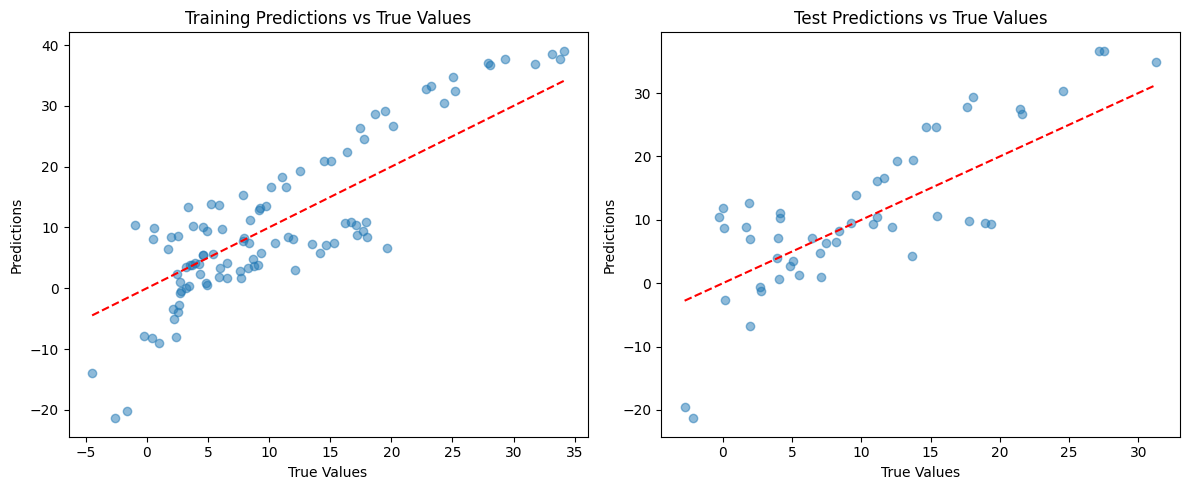


Model Evaluation:
Training MSE: 46.6020
Test MSE: 53.4149

Active terms:
constant: 0.042
x2*log(x1): 1.576
x2*sin(x2): 1.272


In [336]:
builder, best_model = run_analysis()